# Monkey Classification

#### Import Statements

In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# To Read Data
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
# To Interpret results & obtain plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

from pathlib import Path
from os import listdir
import torchvision.transforms as transforms

# Constants
NUM_CLASSES = 5
monkey_dict = {"Bald Uakari": 0,
               "Emperor Tamarin": 1,
               "Mandril": 2,
               "Proboscis Monkey": 3,
               "White face saki": 4}

#### Data Loader

##### My Functions

In [2]:
def encode_label_integer(label_str):
    """Encode monkey name in integer. Prep for one hot encoding.

    Args:
        label (string): Monkey name.

    Returns:
        int: Integer encoded monkey name.
    """
    
    return monkey_dict[label_str]


def encode_labels_onehot(labels_int):
    """Encode integer coded monkey names in one hot encoding.

    Args:
        labels_int (list of ints): List of integer coded monkey names.

    Returns:
        tensor: One hot encoded labels.
    """
    # Convert list of integers to tensor
    labels_tensor = torch.tensor(labels_int, dtype=torch.int64)
    
    # One hot encode labels
    one_hot = F.one_hot(labels_tensor, num_classes=NUM_CLASSES).float()
    
    return one_hot


def load_images(path):
    """Loads all images from path folder.

    Args:
        path (Path or string): Path of folder containing the images.

    Returns:
        dict: Key: image name, Value: image
    """
    # Prepare image storage dict
    # Key: image name, Value: image
    images = {}
    
    # Get list of image names inside the path
    image_paths = [path.joinpath(file_name) for file_name in listdir(path)]
    
    # Load images
    for image_path in image_paths:
        images[image_path.name] = plt.imread(image_path).copy()
    
    # Convert images to tensors
    images = {image_name: transforms.functional.to_tensor(image)
              for image_name, image in images.items()}
    
    return images


def load_images_set(path):
    """Loads all images from (training, validation, test) folder.

    Args:
        path (Path or string): Path of (training, validation, test) folder. 

    Returns:
        list: List of (image, label).
    """
    # Prepare image and label storage list (image, label)
    images = []
    
    # Get list of monkey names inside the path
    monkey_paths = [path.joinpath(directory) for directory in listdir(path)]
    
    # Loop over each monkey and load images
    for directory in monkey_paths:
        # Label is name of the monkey
        label = directory.name
        images_in_dir = load_images(directory)
        for image in images_in_dir.values():
            images.append((image, label))
    
    # Integer encode labels
    int_labels = [encode_label_integer(label) for image, label in images]
    # One hot encode labels
    one_hot_labels = encode_labels_onehot(int_labels)
    
    # Reconstruct images list with one hot encoded labels
    images = [(image, one_hot_labels[i]) for i, (image, label) in enumerate(images)]
    
    return images


def get_mean_std(training_images):
    """Get the channel means and stds of images in the training dataset.

    Args:
        images (tensor): Tensor of images.

    Returns:
        tuple: Tuple of channel means.
        tuple: Tuple of channel stds.
    """
    # Concatenate and squeeze all training images and channels
    r_channel = torch.cat([image[:, :, 0] for image in training_images])
    g_channel = torch.cat([image[:, :, 1] for image in training_images])
    b_channel = torch.cat([image[:, :, 2] for image in training_images])
    
    # Calculate mean and std of each channel
    r_mean, r_std = torch.mean(r_channel), torch.std(r_channel)
    g_mean, g_std = torch.mean(g_channel), torch.std(g_channel)
    b_mean, b_std = torch.mean(b_channel), torch.std(b_channel)
    
    return (r_mean, g_mean, b_mean), (r_std, g_std, b_std)


def normalize_images_set(images, means_train, stds_train):
    """Normalize images in (training, validation, test) set.

    Args:
        images (tensor): Tensor of images.
        means_train (sequence): Means of training dataset channels.
        stds_train (sequence): Stds of training dataset channels.

    Returns:
        list: List of normalized images.
    """
    return [transforms.functional.normalize(image, mean=means_train, std=stds_train) for image in images] 

In [3]:
class MonkeyDataset(Dataset):
    # Define constructor for MonkeyDataset class
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        _x = self.data[index]
        _y = self.labels[index]
        return _x, _y


def get_dataset(root):
    """Get and normalize training, validation, and test sets.

    Args:
        root (Path or string): Root path of set folders.

    Returns:
        list of tuples: Training set (image, label).
        list of tuples: Validation set (image, label).
        list of tuples: Test set (image, label).
    """
    # Read training, validation and test set files
    # Get paths
    train_path = Path(root).resolve().joinpath("training")
    val_path = Path(root).resolve().joinpath("validation")
    test_path = Path(root).resolve().joinpath("test")
    
    # Load sets
    train_x_y = load_images_set(train_path)
    val_x_y = load_images_set(val_path)
    test_x_y = load_images_set(test_path)
    # Separate x and y
    train_x, train_y = [x for x, y in train_x_y], [y for x, y in train_x_y]
    val_x, val_y = [x for x, y in val_x_y], [y for x, y in val_x_y]
    test_x, test_y = [x for x, y in test_x_y], [y for x, y in test_x_y]
    
    # Normalize datasets
    # Get mean and std of training set
    ch_means, ch_stds = get_mean_std(train_x)
    # Normalize train, val, and test
    normalized_train_x = normalize_images_set(train_x, ch_means, ch_stds)
    normalized_val_x = normalize_images_set(val_x, ch_means, ch_stds)
    normalized_test_x = normalize_images_set(test_x, ch_means, ch_stds)
    
    # Pack train, val, test sets
    train_dataset = list(zip(normalized_train_x, train_y))
    val_dataset = list(zip(normalized_val_x, val_y))
    test_dataset = list(zip(normalized_test_x, test_y))

    return train_dataset, val_dataset, test_dataset

#### Convolutional Neural Network (CNN)

- 32 filters with size of 3 x 3 with stride 1 and padding 1, ReLU and MaxPool 3 x 3
- 64 filters with size of 3 x 3 with stride 1 and padding 1, ReLU and MaxPool 3 x 3
- 128 filters with size of 3 x 3 with stride 1 and padding 1, ReLU and MaxPool 3 x 3

In [4]:
class CNN(nn.Module):
    def __init__(self):
        # Initialize nn.Module
        super().__init__()
        
        # Construct the network
        # First layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.activation1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3)
        
        # Second layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.activation2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=3)
        
        # Third layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.activation3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=3)
        
        # Fully connected layer
        self.fc = nn.Linear(in_features=3200, out_features=NUM_CLASSES)
        self.activation_fc = nn.Softmax(dim=1)

    def forward(self, X):
        # First layer
        X = self.conv1(X)
        X = self.activation1(X)
        X = self.maxpool1(X)
        
        # Second layer
        X = self.conv2(X)
        X = self.activation2(X)
        X = self.maxpool2(X)
        
        # Third layer
        X = self.conv3(X)
        X = self.activation3(X)
        X = self.maxpool3(X)
        
        # Fully connected layer
        X = torch.flatten(X, start_dim=1)
        X = self.fc(X)
        X = self.activation_fc(X)
        
        return X

### Stochastic Gradient Descent

#### Training with SGD

##### Explanation of choice of metric for deciding on the best model
I chose **validation accuracy** as the metric for assessing the performance of a model. I believe this metric is adequate in this case because of four reasons. First, the dataset is **balanced**. Accuracy can be a misleading metric in cases with unbalanced classes. In those cases, the model can only predict the majority class and get a high score. However, this is not a problem in our dataset. Second, it is **easy to calculate**. Third, all **classes have equal importance**. If classes had different importances, I would have either had to modified the accuracy metric or used another metric altogether. Fourth, **false negatives and false positives have equal importance**.

##### My Functions

In [5]:
def train_one_epoch(train_loader, model, loss_fn, optimizer):
    # Set model to training mode
    model.train()
    
    # Initialize loss accumulator and sample counter
    total_loss = 0
    num_samples = 0
    # Initialize correct prediction counter
    num_correct = 0
    
    # Loop over batches
    for x, y in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        
        # Get prediction
        pred = model(x)
        # Get loss
        loss = loss_fn(pred, y)
        
        # Compute gradients
        loss.backward()
        # Update parameters using SGD
        optimizer.step()
        
        # Accumulate loss and sample count
        total_loss += loss.item() * x.size(0)
        num_samples += x.size(0)
        # Count correct predictions
        num_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        
    # Get average loss for this epoch
    epoch_loss = total_loss / num_samples if num_samples > 0 else 0
    # Get accuracy for this epoch
    epoch_acc = num_correct / num_samples
    
    return epoch_loss, epoch_acc
    

def val_one_epoch(val_loader, model, loss_fn):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize loss accumulator and sample counter
    total_loss = 0
    num_samples = 0
    # Initialize correct prediction counter
    num_correct = 0
    
    # Disable grad - not training
    with torch.no_grad():
        # Loop over batches
        for x, y in val_loader:
            # Get prediction
            pred = model(x)
            # Get loss
            loss = loss_fn(pred, y)
            
            # Accumulate loss and sample count
            total_loss += loss.item() * x.size(0)
            num_samples += x.size(0)
            # Count correct predictions
            num_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        
    # Get average loss for this epoch
    epoch_loss = total_loss / num_samples if num_samples > 0 else 0
    # Get accuracy for this epoch
    epoch_acc = num_correct / num_samples
    
    return epoch_loss, epoch_acc

Epoch number 1
Epoch number 2
Epoch number 3
Epoch number 4
Epoch number 5
Epoch number 6
Epoch number 7
Epoch number 8
Epoch number 9
Epoch number 10
Epoch number 11
Epoch number 12
Epoch number 13
Epoch number 14
Epoch number 15
Epoch number 16
Epoch number 17
Epoch number 18
Epoch number 19
Epoch number 20
Epoch number 21
Epoch number 22
Epoch number 23
Epoch number 24
Epoch number 25
Epoch number 26
Epoch number 27
Epoch number 28
Epoch number 29
Epoch number 30
Epoch number 31
Epoch number 32
Epoch number 33
Epoch number 34
Epoch number 35
Epoch number 36
Epoch number 37
Epoch number 38
Epoch number 39
Epoch number 40
Epoch number 41
Epoch number 42
Epoch number 43
Epoch number 44
Epoch number 45
Epoch number 46
Epoch number 47
Epoch number 48
Epoch number 49
Epoch number 50
Epoch number 51
Epoch number 52
Epoch number 53
Epoch number 54
Epoch number 55
Epoch number 56
Epoch number 57
Epoch number 58
Epoch number 59
Epoch number 60
Epoch number 61
Epoch number 62
Epoch number 63
E

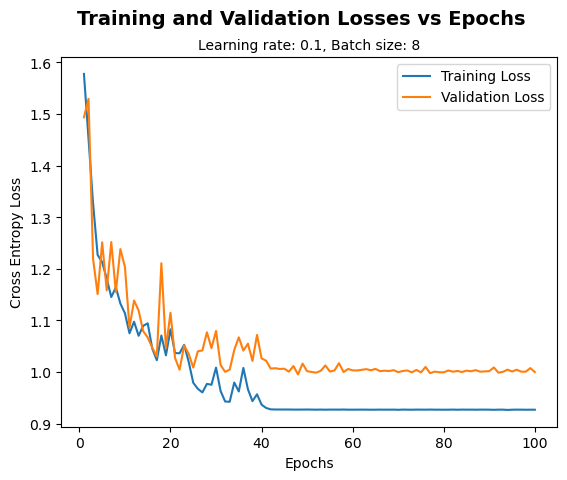

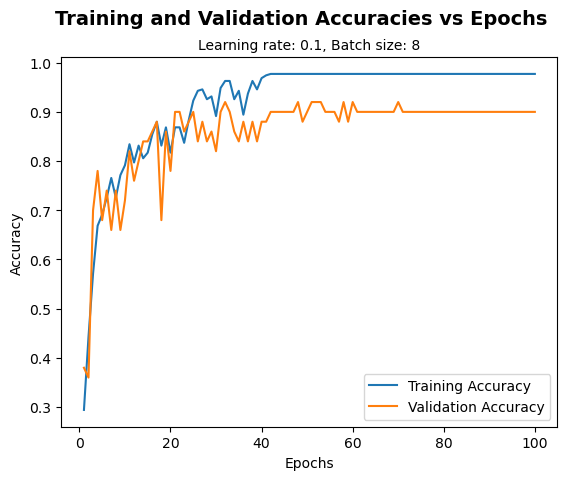

In [6]:
# # Pick your hyper parameters
# max_epoch = 100
# batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]
# learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

# # Set device to GPU if possible
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Get train and val x and y
# train_x_y, val_x_y, _ = get_dataset(Path().resolve().joinpath("dataset"))
# # Separate x and y
# train_x, train_y = torch.stack([x for x, y in train_x_y]), torch.stack([y for x, y in train_x_y])
# train_x = train_x.to(device)
# train_y = train_y.to(device)
# val_x, val_y = torch.stack([x for x, y in val_x_y]), torch.stack([y for x, y in val_x_y])
# val_x = val_x.to(device)
# val_y = val_y.to(device)

# # Loop over batch sizes and learning rates
# for batch_size in batch_sizes:
#     for learning_rate in learning_rates:
#         # Create train dataset loader
#         train_set = MonkeyDataset(train_x, train_y)
#         train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
#         # Create validation dataset loader
#         val_set = MonkeyDataset(val_x, val_y)
#         val_loader = DataLoader(dataset=val_set, batch_size=batch_size)

#         # Initialize your network
#         model = CNN()
#         model = model.to(device)

#         # Define your loss function
#         loss_fn = nn.CrossEntropyLoss()

#         # SGD optimizer
#         optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4)

#         # Init training stat storages
#         train_losses = []
#         train_accs = []
#         val_losses = []
#         val_accs = []
#         # Init best validation
#         best_val_acc = 0

#         # Training loop
#         for epoch in range(max_epoch):
#             # Print current epoch number
#             print(f"Epoch number {epoch + 1}")
            
#             # Training pass
#             epoch_loss, epoch_acc = train_one_epoch(train_loader, model, loss_fn, optimizer)
#             # Append stats
#             train_losses.append(epoch_loss)
#             train_accs.append(epoch_acc)
            
#             # Validation pass
#             epoch_loss, epoch_acc = val_one_epoch(val_loader, model, loss_fn)
#             # Append stats
#             val_losses.append(epoch_loss)
#             val_accs.append(epoch_acc)
            
#             # Save model if it has the best val acc so far
#             if epoch_acc > best_val_acc:
#                 # Update best_val_acc
#                 best_val_acc = epoch_acc
#                 # Save the model
#                 model_name = f"acc{best_val_acc} bs{batch_size} lr{learning_rate} epo{epoch + 1}.pth"
#                 model_path = Path().resolve().joinpath("models", model_name)
#                 torch.save(model.state_dict(), model_path)

#         # Plot losses vs epoch
#         plt.figure()
#         plt.suptitle("Training and Validation Losses vs Epochs", fontsize=14, weight="bold")
#         plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
#         plt.xlabel("Epochs")
#         plt.ylabel("Cross Entropy Loss")
#         plt.plot(range(1, max_epoch + 1), train_losses, label="Training Loss")
#         plt.plot(range(1, max_epoch + 1), val_losses, label="Validation Loss")
#         plt.legend(loc="upper right")
#         figure_name = f"acc{best_val_acc} bs{batch_size} lr{learning_rate} epo{epoch + 1} loss.png"
#         figure_path = Path().resolve().joinpath("figures", figure_name)
#         plt.savefig(figure_path)
#         plt.show()
#         # Plot accs vs epoch
#         plt.figure()
#         plt.suptitle("Training and Validation Accuracies vs Epochs", fontsize=14, weight="bold")
#         plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
#         plt.xlabel("Epochs")
#         plt.ylabel("Accuracy")
#         plt.plot(range(1, max_epoch + 1), train_accs, label="Training Accuracy")
#         plt.plot(range(1, max_epoch + 1), val_accs, label="Validation Accuracy")
#         plt.legend(loc="lower right")
#         figure_name = f"acc{best_val_acc} bs{batch_size} lr{learning_rate} epo{epoch + 1} acc.png"
#         figure_path = Path().resolve().joinpath("figures", figure_name)
#         plt.savefig(figure_path)
#         plt.show()

# Pick your hyper parameters
max_epoch = 100
batch_size = 8
learning_rate = 1e-1

# Set device to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get train and val x and y
train_x_y, val_x_y, _ = get_dataset(Path().resolve().joinpath("dataset"))
# Separate x and y
train_x, train_y = torch.stack([x for x, y in train_x_y]), torch.stack([y for x, y in train_x_y])
train_x = train_x.to(device)
train_y = train_y.to(device)
val_x, val_y = torch.stack([x for x, y in val_x_y]), torch.stack([y for x, y in val_x_y])
val_x = val_x.to(device)
val_y = val_y.to(device)

# Create train dataset loader
train_set = MonkeyDataset(train_x, train_y)
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
# Create validation dataset loader
val_set = MonkeyDataset(val_x, val_y)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size)

# Initialize your network
model = CNN()
model = model.to(device)

# Define your loss function
loss_fn = nn.CrossEntropyLoss()

# SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4)

# Init training stat storages
train_losses = []
train_accs = []
val_losses = []
val_accs = []
# Init best validation
best_val_acc = 0

# Training loop
for epoch in range(max_epoch):
    # Print current epoch number
    print(f"Epoch number {epoch + 1}")
    
    # Training pass
    epoch_loss, epoch_acc = train_one_epoch(train_loader, model, loss_fn, optimizer)
    # Append stats
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Validation pass
    epoch_loss, epoch_acc = val_one_epoch(val_loader, model, loss_fn)
    # Append stats
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)
    
    # Save model if it has the best val acc so far
    if epoch_acc > best_val_acc:
        # Update best_val_acc
        best_val_acc = epoch_acc
        # Save the model
        model_path = Path().resolve().joinpath("best_cnn_sgd.pth")
        torch.save(model.state_dict(), model_path)

# Plot losses vs epoch
plt.figure()
plt.suptitle("Training and Validation Losses vs Epochs", fontsize=14, weight="bold")
plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(range(1, max_epoch + 1), train_losses, label="Training Loss")
plt.plot(range(1, max_epoch + 1), val_losses, label="Validation Loss")
plt.legend(loc="upper right")
plt.show()
# Plot accs vs epoch
plt.figure()
plt.suptitle("Training and Validation Accuracies vs Epochs", fontsize=14, weight="bold")
plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, max_epoch + 1), train_accs, label="Training Accuracy")
plt.plot(range(1, max_epoch + 1), val_accs, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.show()

#### Test with SGD

##### My Functions

In [7]:
def test_model(test_loader, model):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize y_pred
    y_pred = []
    
    # Disable grad - not training
    with torch.no_grad():
        # Loop over batches
        for x, y in test_loader:
            # Get prediction
            pred = model(x)
            # Concatenate prediction to y_pred
            y_pred += list(torch.argmax(pred, dim=1).cpu().numpy())
    
    return y_pred

<Figure size 640x480 with 0 Axes>

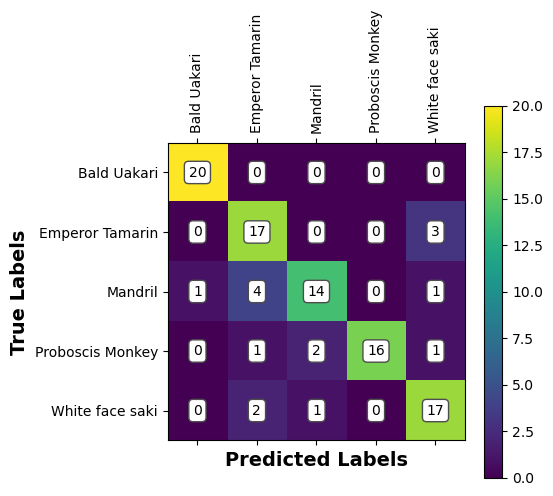

Accuracy = 0.84
Macro Precision = 0.85
Macro Recall = 0.84
Macro F1 = 0.84


In [8]:
# Set device to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get test x and y
_, _, test_x_y = get_dataset(Path().resolve().joinpath("dataset"))
# Separate x and y
test_x, test_y = torch.stack([x for x, y in test_x_y]), torch.stack([y for x, y in test_x_y])
test_x = test_x.to(device)
test_y = test_y.to(device)

# Create test dataset loader
test_set = MonkeyDataset(test_x, test_y)
test_loader = DataLoader(dataset=test_set, batch_size=8)

# Load the best model
model = CNN()
model.load_state_dict(torch.load(Path().resolve().joinpath("best_cnn_sgd.pth")))
model = model.to(device)

# Get predictions
y_pred = test_model(test_loader, model)
# Get true labels
y_true = list(torch.argmax(test_y, dim=1).cpu().numpy())

# Get confusion matrix
test_conf_matrix = confusion_matrix(y_true, y_pred)
# Get accuracy
test_acc = accuracy_score(y_true, y_pred)
# Get macro precision
test_precision = precision_score(y_true, y_pred, average="macro")
# Get macro recall
test_recall = recall_score(y_true, y_pred, average="macro")
# Get macro f1 score
test_f1_score = f1_score(y_true, y_pred, average="macro")

# Report metrics
# Confusion matrix heatmap
plt.figure()
plt.matshow(test_conf_matrix)
for (x, y), value in np.ndenumerate(test_conf_matrix):
    plt.text(y, x, f"{value}", va="center", ha="center", bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xlabel("Predicted Labels", fontsize=14, weight="bold")
plt.ylabel("True Labels", fontsize=14, weight="bold")
plt.xticks(list(range(5)), list(monkey_dict.keys()), rotation=90)
plt.yticks(list(range(5)), list(monkey_dict.keys()))
plt.colorbar()
plt.show()
# Other metrics
print(f"Accuracy = {test_acc:.2f}\n"
      f"Macro Precision = {test_precision:.2f}\n"
      f"Macro Recall = {test_recall:.2f}\n"
      f"Macro F1 = {test_f1_score:.2f}")

### Adam Optimizer

#### Training with ADAM

##### Explanation of choice of metric for deciding on the best model
I chose **validation accuracy** as the metric for assessing the performance of a model. I believe this metric is adequate in this case because of four reasons. First, the dataset is **balanced**. Accuracy can be a misleading metric in cases with unbalanced classes. In those cases, the model can only predict the majority class and get a high score. However, this is not a problem in our dataset. Second, it is **easy to calculate**. Third, all **classes have equal importance**. If classes had different importances, I would have either had to modified the accuracy metric or used another metric altogether. Fourth, **false negatives and false positives have equal importance**.

Epoch number 1
Epoch number 2
Epoch number 3
Epoch number 4
Epoch number 5
Epoch number 6
Epoch number 7
Epoch number 8
Epoch number 9
Epoch number 10
Epoch number 11
Epoch number 12
Epoch number 13
Epoch number 14
Epoch number 15
Epoch number 16
Epoch number 17
Epoch number 18
Epoch number 19
Epoch number 20
Epoch number 21
Epoch number 22
Epoch number 23
Epoch number 24
Epoch number 25
Epoch number 26
Epoch number 27
Epoch number 28
Epoch number 29
Epoch number 30
Epoch number 31
Epoch number 32
Epoch number 33
Epoch number 34
Epoch number 35
Epoch number 36
Epoch number 37
Epoch number 38
Epoch number 39
Epoch number 40
Epoch number 41
Epoch number 42
Epoch number 43
Epoch number 44
Epoch number 45
Epoch number 46
Epoch number 47
Epoch number 48
Epoch number 49
Epoch number 50
Epoch number 51
Epoch number 52
Epoch number 53
Epoch number 54
Epoch number 55
Epoch number 56
Epoch number 57
Epoch number 58
Epoch number 59
Epoch number 60
Epoch number 61
Epoch number 62
Epoch number 63
E

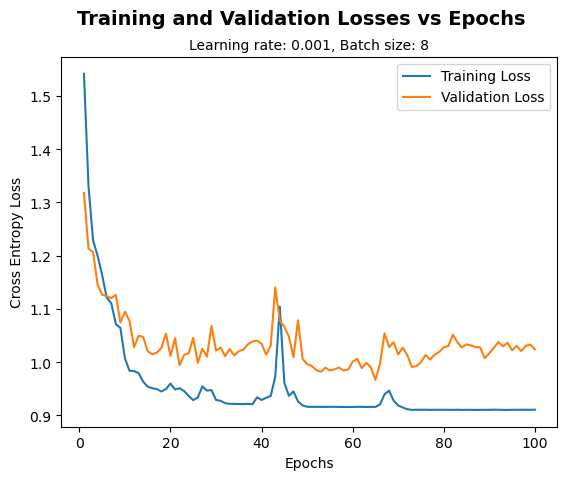

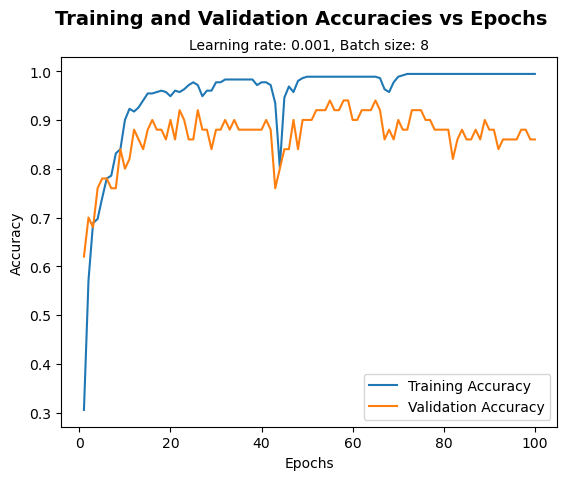

In [9]:
# # Pick your hyper parameters
# max_epoch = 100
# batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]
# learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

# # Set device to GPU if possible
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Get train and val x and y
# train_x_y, val_x_y, _ = get_dataset(Path().resolve().joinpath("dataset"))
# # Separate x and y
# train_x, train_y = torch.stack([x for x, y in train_x_y]), torch.stack([y for x, y in train_x_y])
# train_x = train_x.to(device)
# train_y = train_y.to(device)
# val_x, val_y = torch.stack([x for x, y in val_x_y]), torch.stack([y for x, y in val_x_y])
# val_x = val_x.to(device)
# val_y = val_y.to(device)

# # Loop over batch sizes and learning rates
# for batch_size in batch_sizes:
#     for learning_rate in learning_rates:
#         # Create train dataset loader
#         train_set = MonkeyDataset(train_x, train_y)
#         train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
#         # Create validation dataset loader
#         val_set = MonkeyDataset(val_x, val_y)
#         val_loader = DataLoader(dataset=val_set, batch_size=batch_size)

#         # Initialize your network
#         model = CNN()
#         model = model.to(device)

#         # Define your loss function
#         loss_fn = nn.CrossEntropyLoss()

#         # ADAM optimizer
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

#         # Init training stat storages
#         train_losses = []
#         train_accs = []
#         val_losses = []
#         val_accs = []
#         # Init best validation
#         best_val_acc = 0

#         # Training loop
#         for epoch in range(max_epoch):
#             # Print current epoch number
#             print(f"Epoch number {epoch + 1}")
            
#             # Training pass
#             epoch_loss, epoch_acc = train_one_epoch(train_loader, model, loss_fn, optimizer)
#             # Append stats
#             train_losses.append(epoch_loss)
#             train_accs.append(epoch_acc)
            
#             # Validation pass
#             epoch_loss, epoch_acc = val_one_epoch(val_loader, model, loss_fn)
#             # Append stats
#             val_losses.append(epoch_loss)
#             val_accs.append(epoch_acc)
            
#             # Save model if it has the best val acc so far
#             if epoch_acc > best_val_acc:
#                 # Update best_val_acc
#                 best_val_acc = epoch_acc
#                 # Save the model
#                 model_name = f"acc{best_val_acc} bs{batch_size} lr{learning_rate} epo{epoch + 1}.pth"
#                 model_path = Path().resolve().joinpath("models_adam", model_name)
#                 torch.save(model.state_dict(), model_path)

#         # Plot losses vs epoch
#         plt.figure()
#         plt.suptitle("Training and Validation Losses vs Epochs", fontsize=14, weight="bold")
#         plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
#         plt.xlabel("Epochs")
#         plt.ylabel("Cross Entropy Loss")
#         plt.plot(range(1, max_epoch + 1), train_losses, label="Training Loss")
#         plt.plot(range(1, max_epoch + 1), val_losses, label="Validation Loss")
#         plt.legend(loc="upper right")
#         figure_name = f"acc{best_val_acc} bs{batch_size} lr{learning_rate} epo{epoch + 1} loss.png"
#         figure_path = Path().resolve().joinpath("figures_adam", figure_name)
#         plt.savefig(figure_path)
#         plt.show()
#         # Plot accs vs epoch
#         plt.figure()
#         plt.suptitle("Training and Validation Accuracies vs Epochs", fontsize=14, weight="bold")
#         plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
#         plt.xlabel("Epochs")
#         plt.ylabel("Accuracy")
#         plt.plot(range(1, max_epoch + 1), train_accs, label="Training Accuracy")
#         plt.plot(range(1, max_epoch + 1), val_accs, label="Validation Accuracy")
#         plt.legend(loc="lower right")
#         figure_name = f"acc{best_val_acc} bs{batch_size} lr{learning_rate} epo{epoch + 1} acc.png"
#         figure_path = Path().resolve().joinpath("figures_adam", figure_name)
#         plt.savefig(figure_path)
#         plt.show()

# Pick your hyper parameters
max_epoch = 100
batch_size = 8
learning_rate = 1e-3

# Set device to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get train and val x and y
train_x_y, val_x_y, _ = get_dataset(Path().resolve().joinpath("dataset"))
# Separate x and y
train_x, train_y = torch.stack([x for x, y in train_x_y]), torch.stack([y for x, y in train_x_y])
train_x = train_x.to(device)
train_y = train_y.to(device)
val_x, val_y = torch.stack([x for x, y in val_x_y]), torch.stack([y for x, y in val_x_y])
val_x = val_x.to(device)
val_y = val_y.to(device)

# Create train dataset loader
train_set = MonkeyDataset(train_x, train_y)
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
# Create validation dataset loader
val_set = MonkeyDataset(val_x, val_y)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size)

# Initialize your network
model = CNN()
model = model.to(device)

# Define your loss function
loss_fn = nn.CrossEntropyLoss()

# SGD optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)

# Init training stat storages
train_losses = []
train_accs = []
val_losses = []
val_accs = []
# Init best validation
best_val_acc = 0

# Training loop
for epoch in range(max_epoch):
    # Print current epoch number
    print(f"Epoch number {epoch + 1}")
    
    # Training pass
    epoch_loss, epoch_acc = train_one_epoch(train_loader, model, loss_fn, optimizer)
    # Append stats
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Validation pass
    epoch_loss, epoch_acc = val_one_epoch(val_loader, model, loss_fn)
    # Append stats
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)
    
    # Save model if it has the best val acc so far
    if epoch_acc > best_val_acc:
        # Update best_val_acc
        best_val_acc = epoch_acc
        # Save the model
        model_path = Path().resolve().joinpath("best_cnn_adam.pth")
        torch.save(model.state_dict(), model_path)

# Plot losses vs epoch
plt.figure()
plt.suptitle("Training and Validation Losses vs Epochs", fontsize=14, weight="bold")
plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(range(1, max_epoch + 1), train_losses, label="Training Loss")
plt.plot(range(1, max_epoch + 1), val_losses, label="Validation Loss")
plt.legend(loc="upper right")
plt.show()
# Plot accs vs epoch
plt.figure()
plt.suptitle("Training and Validation Accuracies vs Epochs", fontsize=14, weight="bold")
plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, max_epoch + 1), train_accs, label="Training Accuracy")
plt.plot(range(1, max_epoch + 1), val_accs, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.show()

#### Test with ADAM

<Figure size 640x480 with 0 Axes>

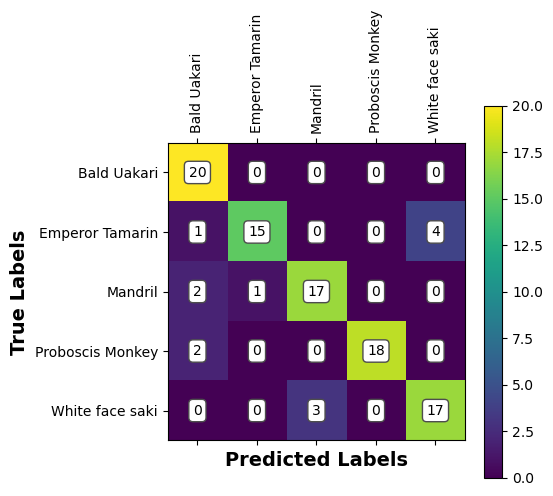

Accuracy = 0.87
Macro Precision = 0.88
Macro Recall = 0.87
Macro F1 = 0.87


In [10]:
# Set device to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get test x and y
_, _, test_x_y = get_dataset(Path().resolve().joinpath("dataset"))
# Separate x and y
test_x, test_y = torch.stack([x for x, y in test_x_y]), torch.stack([y for x, y in test_x_y])
test_x = test_x.to(device)
test_y = test_y.to(device)

# Create test dataset loader
test_set = MonkeyDataset(test_x, test_y)
test_loader = DataLoader(dataset=test_set, batch_size=8)

# Load the best model
model = CNN()
model.load_state_dict(torch.load(Path().resolve().joinpath("best_cnn_adam.pth")))
model = model.to(device)

# Get predictions
y_pred = test_model(test_loader, model)
# Get true labels
y_true = list(torch.argmax(test_y, dim=1).cpu().numpy())

# Get confusion matrix
test_conf_matrix = confusion_matrix(y_true, y_pred)
# Get accuracy
test_acc = accuracy_score(y_true, y_pred)
# Get macro precision
test_precision = precision_score(y_true, y_pred, average="macro")
# Get macro recall
test_recall = recall_score(y_true, y_pred, average="macro")
# Get macro f1 score
test_f1_score = f1_score(y_true, y_pred, average="macro")

# Report metrics
# Confusion matrix heatmap
plt.figure()
plt.matshow(test_conf_matrix)
for (x, y), value in np.ndenumerate(test_conf_matrix):
    plt.text(y, x, f"{value}", va="center", ha="center", bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xlabel("Predicted Labels", fontsize=14, weight="bold")
plt.ylabel("True Labels", fontsize=14, weight="bold")
plt.xticks(list(range(5)), list(monkey_dict.keys()), rotation=90)
plt.yticks(list(range(5)), list(monkey_dict.keys()))
plt.colorbar()
plt.show()
# Other metrics
print(f"Accuracy = {test_acc:.2f}\n"
      f"Macro Precision = {test_precision:.2f}\n"
      f"Macro Recall = {test_recall:.2f}\n"
      f"Macro F1 = {test_f1_score:.2f}")

##### Discussion of SGD vs ADAM Optimizers
Starting with the optimal learning rate and batch sizes, it can be seen that the optimal learning rate of the ADAM optimizer is smaller compared to SGD. This statement, however, is a bit misleading. Since the ADAM algorithm dynamically adjusts the learning rate, the input learning rate is just a starting point. The optimal batch sizes for both optimizers are the same.<br>

Comparing the loss and accuracy plots, it can be observed that the ADAM optimizer produces more jagged lines. This can be helpful in avoiding local minima.<br>

Comparing the test results, both optimizers perform similarly. In this specific case, the model trained using the SGD optimizer has an accuracy of 84% while the model trained using the ADAM optimizer has an accuracy of 87%.<br>

Comparing the run times, the ADAM optimizer requires slightly more computational resources and therefore time. However, the difference is minute and should not be taken into consideration when choosing an optimizer.<br>

In general, the dynamic adaptation capabilities of the ADAM optimizer makes it a more robust solution for neural network training. However, the SGD optimizer can perform just as well if the hyperparameters of the algorithm are selected appropriately. There is also some evidance that SGD generalizes better than ADAM (https://arxiv.org/abs/1705.08292).

### Transfer Learning

#### Training with Transfer Learning

##### Explanation of choice of metric for deciding on the best model
I chose **validation accuracy** as the metric for assessing the performance of a model. I believe this metric is adequate in this case because of four reasons. First, the dataset is **balanced**. Accuracy can be a misleading metric in cases with unbalanced classes. In those cases, the model can only predict the majority class and get a high score. However, this is not a problem in our dataset. Second, it is **easy to calculate**. Third, all **classes have equal importance**. If classes had different importances, I would have either had to modified the accuracy metric or used another metric altogether. Fourth, **false negatives and false positives have equal importance**.

/home/mikla/.pyenv/versions/miniconda3-3.11-23.11.0-2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mikla/.pyenv/versions/miniconda3-3.11-23.11.0-2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 1
Epoch number 2
Epoch number 3
Epoch number 4
Epoch number 5
Epoch number 6
Epoch number 7
Epoch number 8
Epoch number 9
Epoch number 10
Epoch number 11
Epoch number 12
Epoch number 13
Epoch number 14
Epoch number 15
Epoch number 16
Epoch number 17
Epoch number 18
Epoch number 19
Epoch number 20


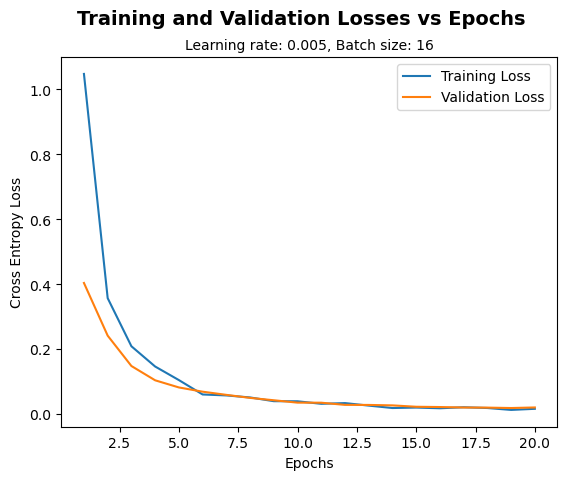

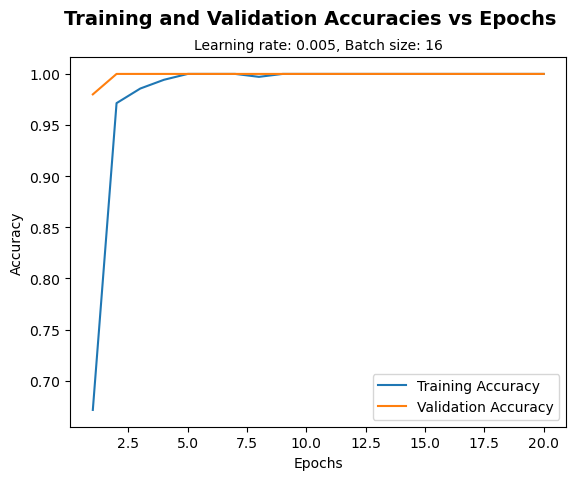

In [11]:
# # Pick your hyper parameters
# max_epoch = 20
# batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]
# learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

# # Set device to GPU if possible
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Get train and val x and y
# train_x_y, val_x_y, _ = get_dataset(Path().resolve().joinpath("dataset"))
# # Separate x and y
# train_x, train_y = torch.stack([x for x, y in train_x_y]), torch.stack([y for x, y in train_x_y])
# train_x = train_x.to(device)
# train_y = train_y.to(device)
# val_x, val_y = torch.stack([x for x, y in val_x_y]), torch.stack([y for x, y in val_x_y])
# val_x = val_x.to(device)
# val_y = val_y.to(device)

# # Loop over batch sizes and learning rates
# for batch_size in batch_sizes:
#     for learning_rate in learning_rates:
#         # Create train dataset loader
#         train_set = MonkeyDataset(train_x, train_y)
#         train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
#         # Create validation dataset loader
#         val_set = MonkeyDataset(val_x, val_y)
#         val_loader = DataLoader(dataset=val_set, batch_size=batch_size)

#         # Initialize your network
#         model = models.resnet18(pretrained=True)
#         num_features = model.fc.in_features
#         model.fc = nn.Linear(num_features, NUM_CLASSES)
#         model = model.to(device)

#         # Define your loss function
#         loss_fn = nn.CrossEntropyLoss()

#         # SGD optimizer
#         optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = 1e-5)

#         # Init training stat storages
#         train_losses = []
#         train_accs = []
#         val_losses = []
#         val_accs = []
#         # Init best validation
#         best_val_acc = 0

#         # Training loop
#         for epoch in range(max_epoch):
#             # Print current epoch number
#             print(f"Epoch number {epoch + 1}")
            
#             # Training pass
#             epoch_loss, epoch_acc = train_one_epoch(train_loader, model, loss_fn, optimizer)
#             # Append stats
#             train_losses.append(epoch_loss)
#             train_accs.append(epoch_acc)
            
#             # Validation pass
#             epoch_loss, epoch_acc = val_one_epoch(val_loader, model, loss_fn)
#             # Append stats
#             val_losses.append(epoch_loss)
#             val_accs.append(epoch_acc)
            
#             # Save model if it has the best val acc so far
#             if epoch_acc > best_val_acc:
#                 # Update best_val_acc
#                 best_val_acc = epoch_acc
#                 # Save the model
#                 model_name = f"acc{best_val_acc} bs{batch_size} lr{learning_rate} epo{epoch + 1}.pth"
#                 model_path = Path().resolve().joinpath("models_transfer", model_name)
#                 torch.save(model.state_dict(), model_path)

#         # Plot losses vs epoch
#         plt.figure()
#         plt.suptitle("Training and Validation Losses vs Epochs", fontsize=14, weight="bold")
#         plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
#         plt.xlabel("Epochs")
#         plt.ylabel("Cross Entropy Loss")
#         plt.plot(range(1, max_epoch + 1), train_losses, label="Training Loss")
#         plt.plot(range(1, max_epoch + 1), val_losses, label="Validation Loss")
#         plt.legend(loc="upper right")
#         figure_name = f"acc{best_val_acc} bs{batch_size} lr{learning_rate} epo{epoch + 1} loss.png"
#         figure_path = Path().resolve().joinpath("figures_transfer", figure_name)
#         plt.savefig(figure_path)
#         plt.show()
#         # Plot accs vs epoch
#         plt.figure()
#         plt.suptitle("Training and Validation Accuracies vs Epochs", fontsize=14, weight="bold")
#         plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
#         plt.xlabel("Epochs")
#         plt.ylabel("Accuracy")
#         plt.plot(range(1, max_epoch + 1), train_accs, label="Training Accuracy")
#         plt.plot(range(1, max_epoch + 1), val_accs, label="Validation Accuracy")
#         plt.legend(loc="lower right")
#         figure_name = f"acc{best_val_acc} bs{batch_size} lr{learning_rate} epo{epoch + 1} acc.png"
#         figure_path = Path().resolve().joinpath("figures_transfer", figure_name)
#         plt.savefig(figure_path)
#         plt.show()

# Pick your hyper parameters
max_epoch = 20
batch_size = 16
learning_rate = 5e-3

# Set device to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get train and val x and y
train_x_y, val_x_y, _ = get_dataset(Path().resolve().joinpath("dataset"))
# Separate x and y
train_x, train_y = torch.stack([x for x, y in train_x_y]), torch.stack([y for x, y in train_x_y])
train_x = train_x.to(device)
train_y = train_y.to(device)
val_x, val_y = torch.stack([x for x, y in val_x_y]), torch.stack([y for x, y in val_x_y])
val_x = val_x.to(device)
val_y = val_y.to(device)

# Create train dataset loader
train_set = MonkeyDataset(train_x, train_y)
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
# Create validation dataset loader
val_set = MonkeyDataset(val_x, val_y)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size)

# Initialize your network
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)
model = model.to(device)

# Define your loss function
loss_fn = nn.CrossEntropyLoss()

# SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = 1e-5)

# Init training stat storages
train_losses = []
train_accs = []
val_losses = []
val_accs = []
# Init best validation
best_val_acc = 0

# Training loop
for epoch in range(max_epoch):
    # Print current epoch number
    print(f"Epoch number {epoch + 1}")
    
    # Training pass
    epoch_loss, epoch_acc = train_one_epoch(train_loader, model, loss_fn, optimizer)
    # Append stats
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Validation pass
    epoch_loss, epoch_acc = val_one_epoch(val_loader, model, loss_fn)
    # Append stats
    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)
    
    # Save model if it has the best val acc so far
    if epoch_acc > best_val_acc:
        # Update best_val_acc
        best_val_acc = epoch_acc
        # Save the model
        model_path = Path().resolve().joinpath("best_cnn_transfer.pth")
        torch.save(model.state_dict(), model_path)

# Plot losses vs epoch
plt.figure()
plt.suptitle("Training and Validation Losses vs Epochs", fontsize=14, weight="bold")
plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(range(1, max_epoch + 1), train_losses, label="Training Loss")
plt.plot(range(1, max_epoch + 1), val_losses, label="Validation Loss")
plt.legend(loc="upper right")
plt.show()
# Plot accs vs epoch
plt.figure()
plt.suptitle("Training and Validation Accuracies vs Epochs", fontsize=14, weight="bold")
plt.title(f"Learning rate: {learning_rate}, Batch size: {batch_size}", fontsize=10)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, max_epoch + 1), train_accs, label="Training Accuracy")
plt.plot(range(1, max_epoch + 1), val_accs, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.show()

#### Test for Transfer Learning

<Figure size 640x480 with 0 Axes>

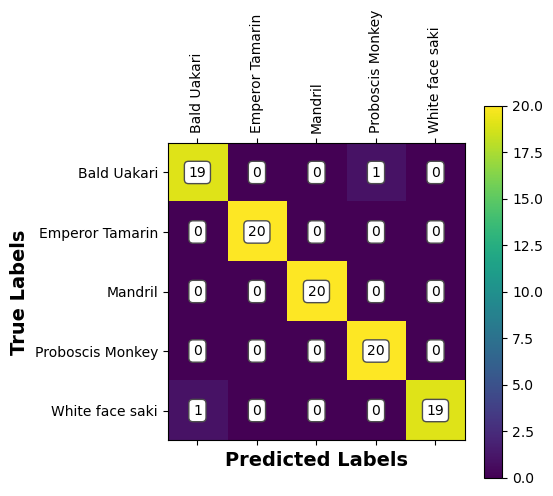

Accuracy = 0.98
Macro Precision = 0.98
Macro Recall = 0.98
Macro F1 = 0.98


In [12]:
# Set device to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get test x and y
_, _, test_x_y = get_dataset(Path().resolve().joinpath("dataset"))
# Separate x and y
test_x, test_y = torch.stack([x for x, y in test_x_y]), torch.stack([y for x, y in test_x_y])
test_x = test_x.to(device)
test_y = test_y.to(device)

# Create test dataset loader
test_set = MonkeyDataset(test_x, test_y)
test_loader = DataLoader(dataset=test_set, batch_size=8)

# Load the best model
# Initialize your network
model = models.resnet18()
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)
model.load_state_dict(torch.load(Path().resolve().joinpath("best_cnn_transfer.pth")))
model = model.to(device)

# Get predictions
y_pred = test_model(test_loader, model)
# Get true labels
y_true = list(torch.argmax(test_y, dim=1).cpu().numpy())

# Get confusion matrix
test_conf_matrix = confusion_matrix(y_true, y_pred)
# Get accuracy
test_acc = accuracy_score(y_true, y_pred)
# Get macro precision
test_precision = precision_score(y_true, y_pred, average="macro")
# Get macro recall
test_recall = recall_score(y_true, y_pred, average="macro")
# Get macro f1 score
test_f1_score = f1_score(y_true, y_pred, average="macro")

# Report metrics
# Confusion matrix heatmap
plt.figure()
plt.matshow(test_conf_matrix)
for (x, y), value in np.ndenumerate(test_conf_matrix):
    plt.text(y, x, f"{value}", va="center", ha="center", bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xlabel("Predicted Labels", fontsize=14, weight="bold")
plt.ylabel("True Labels", fontsize=14, weight="bold")
plt.xticks(list(range(5)), list(monkey_dict.keys()), rotation=90)
plt.yticks(list(range(5)), list(monkey_dict.keys()))
plt.colorbar()
plt.show()
# Other metrics
print(f"Accuracy = {test_acc:.2f}\n"
      f"Macro Precision = {test_precision:.2f}\n"
      f"Macro Recall = {test_recall:.2f}\n"
      f"Macro F1 = {test_f1_score:.2f}")

##### Discussion of training from scratch vs transfer learning
Starting with the loss and accuracy plots, as opposed to training from scratch, transfer learning is able to achieve 100% accuracy in both training and validation sets.<br>

Comparing the test results, training from scratch achieves accuracy scores in the 80% range while transfer learning achieves 98% accuracy.<br>

Comparing the run times, per epoch, training from scratch is much faster. However, transfer learning requires fewer epochs to converge.<br>

In general, it is possible to achieve much better performance using a pretrained model compared to training a model from scratch while keeping the training time constant. Pre-trained weights capture the general details present in most images such as horizontal and vertical lines. While we are fine-tuning the model, we do not have to learn these general details again. Because of this, transfer learning makes it possible to use a much more complex model while keeping the training times short. We would get similar performance if we trained the ResNet18 model from scratch but it would have taken a very long time.